## 基于Backtrader的量化回测教程

### 使用Akshare作为数据源，对ETF基金做策略回测

### 1. 安装依赖

In [2]:
# !pip install tushare==1.2.85
# !pip install akshare -U
# !pip install backtrader==1.9.76.123
# !pip install pandas==1.5.2 --user

### 2.导入相关的Python库

In [3]:
import backtrader as bt
import tushare as ts
import pandas as pd
import akshare as ak
from backtrader.feeds import PandasData
from datetime import datetime as dt
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")

### 3.选取市面上所有的ETF基金

In [5]:
fund_exchange_rank_em_df = ak.fund_exchange_rank_em()
fund_exchange_rank_em_df

,序号,基金代码,基金简称,类型,日期,单位净值,累计净值,近1周,近1月,近3月,近6月,近1年,近2年,近3年,今年来,成立来,成立日期
0,1,516770,华泰柏瑞中证动漫游戏ETF,指数型-股票,2023-09-01,1.1864,1.1864,6.43,-2.20,-21.59,25.48,48.47,39.96,NaN,54.82,18.64,2021-02-25
1,2,159869,华夏中证动漫游戏ETF,指数型-股票,2023-09-01,1.1803,1.1803,6.56,-2.74,-22.43,25.35,48.41,38.03,NaN,55.00,18.03,2021-02-25
2,3,516010,国泰中证动漫游戏ETF,指数型-股票,2023-09-01,1.1694,1.1694,6.54,-2.70,-22.25,24.75,46.89,35.28,NaN,53.30,16.94,2021-02-25
3,4,159985,华夏饲料豆粕期货ETF,商品（不含QDII）,2023-09-01,2.3507,2.3507,1.61,8.64,36.31,22.63,43.98,84.48,128.42,18.24,135.07,2019-09-24
4,5,517500,国泰中证沪港深动漫游戏ETF,指数型-股票,2023-09-01,1.3223,1.3223,4.93,-4.99,-16.27,20.52,43.28,NaN,NaN,45.97,32.23,2022-03-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,798,561980,招商中证半导体产业ETF,指数型-股票,2023-09-01,1.0546,1.0546,5.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.46,2023-08-21
798,799,588020,易方达上证科创板成长ETF,指数型-股票,2023-09-01,1.0263,1.0263,2.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.63,2023-08-23
799,800,159517,银华中证800增强ETF,指数型-股票,2023-09-01,1.0069,1.0069,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.69,2023-08-23
800,801,560590,鹏华中证1000增强ETF,指数型-股票,2023-09-01,1.0000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2023-09-01


### 4.选择成立日期最早的一家作为回测标的

In [6]:
fund_pool = fund_exchange_rank_em_df[fund_exchange_rank_em_df['基金简称'].str.contains('沪深300')].sort_values('成立日期').set_index('基金代码')
fund_pool.head()

,序号,基金简称,类型,日期,单位净值,累计净值,近1周,近1月,近3月,近6月,近1年,近2年,近3年,今年来,成立来,成立日期
基金代码,,,,,,,,,,,,,,,,
510300,359,华泰柏瑞沪深300ETF,指数型-股票,2023-09-01,3.8645,1.6561,2.22,-5.00,1.37,-6.31,-4.48,-19.41,-17.72,-0.29,68.19,2012-05-04
159919,350,嘉实沪深300ETF,指数型-股票,2023-09-01,3.9349,1.7647,2.25,-5.00,1.41,-6.27,-4.34,-19.20,-17.53,-0.14,74.93,2012-05-07
510330,349,华夏沪深300ETF,指数型-股票,2023-09-01,3.8694,1.8762,2.25,-5.01,1.43,-6.26,-4.34,-19.27,-17.50,-0.17,92.54,2012-12-25
159925,330,南方沪深300ETF,指数型-股票,2023-09-01,1.9065,1.6715,2.28,-4.91,1.58,-5.99,-3.85,-18.54,-15.24,0.25,90.65,2013-02-18
510310,331,易方达沪深300发起式ETF,指数型-股票,2023-09-01,1.8449,1.8449,2.25,-4.97,1.51,-6.07,-3.88,-18.29,-15.90,0.12,84.49,2013-03-06


In [7]:
fund = fund_pool.index[0]
fund

'510300'

### 5.获取ETF基金行情历史数据

In [8]:
fund_etf_fund_info_em_df = ak.fund_etf_fund_info_em(fund=fund, start_date='20150101', end_date='20230401')
fund_etf_fund_info_em_df

,净值日期,单位净值,累计净值,日增长率,申购状态,赎回状态
0,2015-01-05,3.6782,1.3945,3.05,场内买入,场内卖出
1,2015-01-06,3.6757,1.3935,-0.07,场内买入,场内卖出
2,2015-01-07,3.6741,1.3930,-0.04,场内买入,场内卖出
3,2015-01-08,3.5884,1.3612,-2.33,场内买入,场内卖出
4,2015-01-09,3.5749,1.3562,-0.38,场内买入,场内卖出
...,...,...,...,...,...,...
2007,2023-03-27,4.0093,1.7098,-0.37,场内买入,场内卖出
2008,2023-03-28,3.9963,1.7050,-0.32,场内买入,场内卖出
2009,2023-03-29,4.0030,1.7075,0.17,场内买入,场内卖出
2010,2023-03-30,4.0353,1.7195,0.81,场内买入,场内卖出


### 6.清洗行情数据

In [9]:
fund_etf_fund_info_em_df.rename(columns={'净值日期':'date','累计净值':'close'},inplace=True)
fund_etf_fund_info_em_df = fund_etf_fund_info_em_df[['date','close']]
fund_etf_fund_info_em_df

,date,close
0,2015-01-05,1.3945
1,2015-01-06,1.3935
2,2015-01-07,1.3930
3,2015-01-08,1.3612
4,2015-01-09,1.3562
...,...,...
2007,2023-03-27,1.7098
2008,2023-03-28,1.7050
2009,2023-03-29,1.7075
2010,2023-03-30,1.7195


### 注意：基金数据只有一个净值，但是backtrader中需要加入高开低收等数据，因此需要自己添加相应的列

In [10]:
fund_etf_fund_info_em_df['open'] = fund_etf_fund_info_em_df['close']
fund_etf_fund_info_em_df['high'] = fund_etf_fund_info_em_df['close']
fund_etf_fund_info_em_df['low'] = fund_etf_fund_info_em_df['close']
fund_etf_fund_info_em_df['volume'] = 1000

fund_etf_fund_info_em_df = fund_etf_fund_info_em_df[['date', 'open', 'high', 'low', 'close', 'volume']]
fund_etf_fund_info_em_df

,date,open,high,low,close,volume
0,2015-01-05,1.3945,1.3945,1.3945,1.3945,1000
1,2015-01-06,1.3935,1.3935,1.3935,1.3935,1000
2,2015-01-07,1.3930,1.3930,1.3930,1.3930,1000
3,2015-01-08,1.3612,1.3612,1.3612,1.3612,1000
4,2015-01-09,1.3562,1.3562,1.3562,1.3562,1000
...,...,...,...,...,...,...
2007,2023-03-27,1.7098,1.7098,1.7098,1.7098,1000
2008,2023-03-28,1.7050,1.7050,1.7050,1.7050,1000
2009,2023-03-29,1.7075,1.7075,1.7075,1.7075,1000
2010,2023-03-30,1.7195,1.7195,1.7195,1.7195,1000


In [11]:
fund_etf_fund_info_em_df.date = pd.to_datetime(fund_etf_fund_info_em_df.date)

### 7.设置回测参数

In [12]:
start_date = '20150101'
end_date = '20220101'

### 8.编写策略类

In [15]:
class SmaCross(bt.Strategy):
    # 定义参数
    params = dict(
                period_fast=5, # 5日均线
                period_slow=10 # 10日均线
            )
        
    def __init__(self):
        # 移动平均线指标
        self.move_average_fast = bt.ind.MovingAverageSimple(self.datas[0].close, period=self.params.period_fast)
        self.move_average_slow = bt.ind.MovingAverageSimple(self.datas[0].close, period=self.params.period_slow)
        
    def next(self):
        size = int(self.broker.getvalue() / self.datas[0].close // 100 * 100)
        if not self.position.size: #还没有仓位
            # 当日5日均线上穿10日均线，创建买单，全仓买入
            if self.move_average_fast.sma[-1] < self.move_average_slow.sma[-1] and self.move_average_fast.sma[0] > self.move_average_slow.sma[0]:
                self.buy(size=size)
        # 有仓位， 并且5日均线下穿10日均线， 平仓
        elif self.move_average_fast.sma[-1] > self.move_average_slow.sma[-1] and self.move_average_fast.sma[0] < self.move_average_slow.sma[0]:
            self.close()

### 9.开始回测

In [16]:
# 创建回测引擎对象
cerebro = bt.Cerebro()

etf_data = PandasData(
                dataname=fund_etf_fund_info_em_df,
                datetime=0, # 日期列
                open=1, # 开盘价所在列
                high=2, # 最高价所在列
                low=3, # 最低价所在列
                close=4, # 收盘价所在列
                volume=5,
                fromdate=dt.strptime(start_date, '%Y%m%d'), # 起始日 dt.strptime(start, '%Y%m%d')
                todate=dt.strptime(end_date, '%Y%m%d'), # 结束日
            )

cerebro.adddata(etf_data, name='etf')    

In [17]:
start_cash=100000

In [18]:
cerebro.addstrategy(SmaCross)

0

In [19]:
# 设置现金
cerebro.broker.setcash(start_cash)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

In [20]:
print('最终市值： %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

最终市值： 100000.00


In [21]:
portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, _,_,_ = portfolio_stats.get_pf_items()

                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2021-12-31
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -18.55%
CAGR﹪                     -2.01%

Sharpe                     -0.3
Prob. Sharpe Ratio         21.41%
Smart Sharpe               -0.29
Sortino                    -0.4
Smart Sortino              -0.38
Sortino/√2                 -0.28
Smart Sortino/√2           -0.27
Omega                      0.89

Max Drawdown               -32.87%
Longest DD Days            1466
Volatility (ann.)          8.77%
Calmar                     -0.06
Skew                       -1.3
Kurtosis                   29.16

Expected Daily %           -0.01%
Expected Monthly %         -0.24%
Expected Yearly %          -2.89%
Kelly Criterion            -5.96%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.92%
Expected Shortfall (cVaR)  -0.92%

Max Consecutive 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-12-27,2021-11-30,2021-12-31,1466,-32.868189,-32.622767
2,2015-10-28,2016-06-13,2016-08-12,290,-9.912391,-8.733376
3,2015-05-27,2015-05-28,2015-09-25,122,-6.685834,-6.590537
4,2015-01-28,2015-02-02,2015-05-20,113,-5.815260,-4.493610
5,2016-08-16,2016-10-17,2017-05-24,282,-5.390962,-4.766691


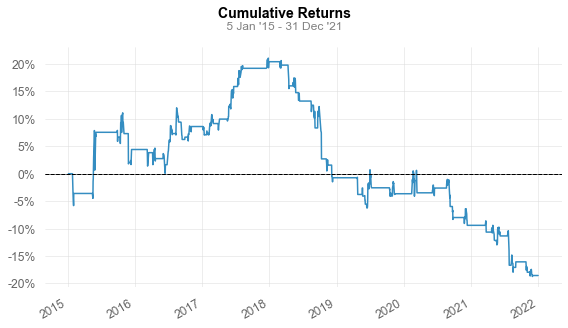

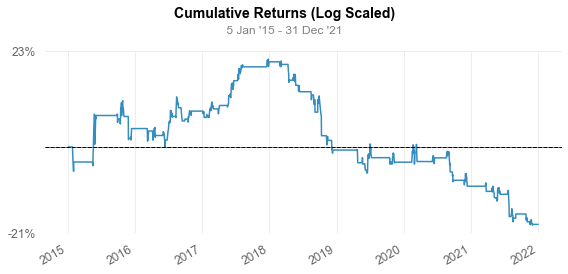

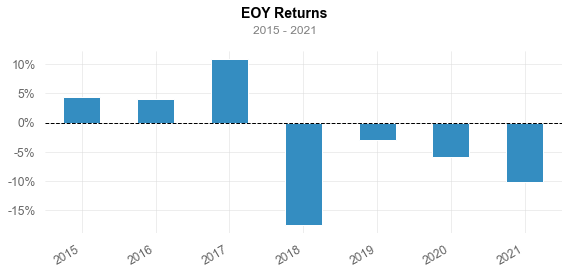

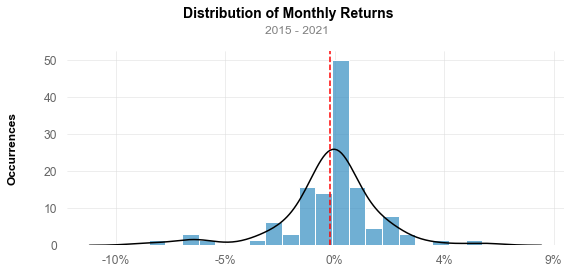

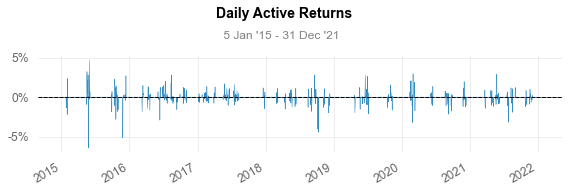

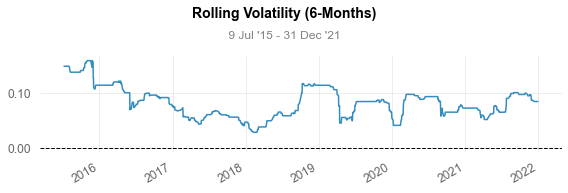

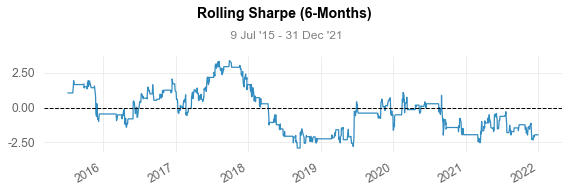

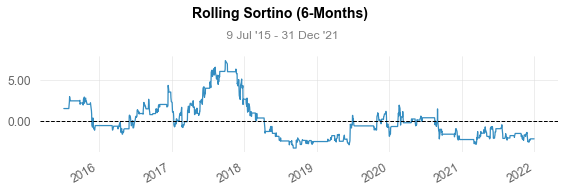

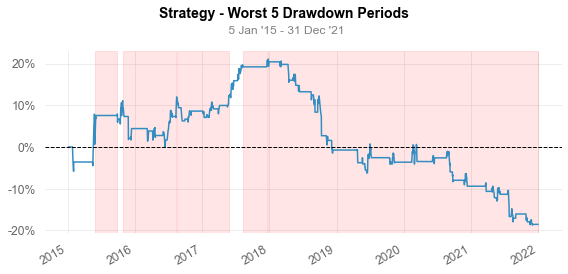

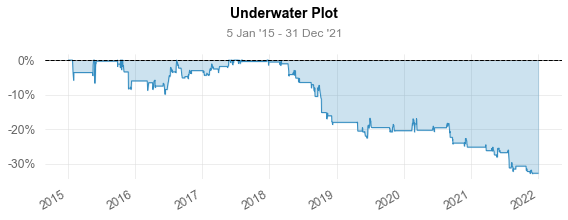

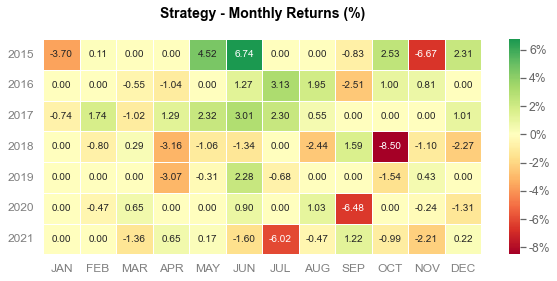

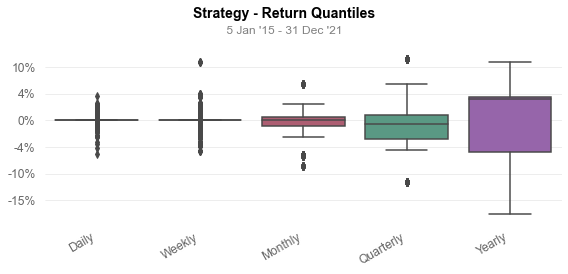

In [22]:
returns.index=returns.index.tz_convert(None)
qs.reports.full(returns)